# **Introduction**

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from six.moves import cPickle as pickle
import pandas as pd
from pandas import DataFrame
import gzip
import seaborn as sns
import string
from time import time
from urllib.request import urlretrieve
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))


from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

DATASET_NAME = 'reviews_Apps_for_Android_5.json.gz'

FIG_SIZE = (14,8)

RAN_STATE = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Data Exploration

In [2]:
url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent
                
def maybe_download(filename, expected_bytes, force=False):
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ =  urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

test = maybe_download(DATASET_NAME, 95509687)

Attempting to download: reviews_Apps_for_Android_5.json.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified reviews_Apps_for_Android_5.json.gz


In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    data = {}
    for d in parse(path):
        data[i] = d
        i += 1
    return pd.DataFrame.from_dict(data, orient='index')

pickle_file_name = (DATASET_NAME[:-8]+'.pickle')

if os.path.exists(pickle_file_name):
    print ('Pickled file already present, loading...')
    data = pd.read_pickle(pickle_file_name)
    print ('Pickle file loaded.')
else:
    data = getDF(DATASET_NAME)
    data.to_pickle(pickle_file_name)

In [4]:
data.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,"11 2, 2013"
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,"12 5, 2011"
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,"05 21, 2012"


In [5]:
df = data.iloc[:, [6,5,3]]

df['helpful_numerator'] = df['helpful'].apply(lambda x: x[0])
df['helpful_denominator'] = df['helpful'].apply(lambda x: x[1])

del df['helpful']

print (df.isnull().sum())

summary                0
overall                0
helpful_numerator      0
helpful_denominator    0
dtype: int64


In [6]:
df.describe()

,overall,helpful_numerator,helpful_denominator
count,752937.000000,752937.000000,752937.000000
mean,3.968931,3.435937,4.473125
std,1.342484,37.328951,43.688824
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,5.000000,1.000000,2.000000
max,5.000000,8116.000000,9258.000000


Exploratory Visualization

In [7]:
print (df['helpful_numerator'].idxmax(axis=0, skipna=True))
print (df['helpful_denominator'].idxmax(axis=0, skipna=True))

510127
510127


In [8]:
df.iloc[[510127,510128]]

,summary,overall,helpful_numerator,helpful_denominator
510127,THIS GAME IS AWESOME!!!,5.0,8116,9258
510128,what happened???,1.0,0,2


# **Benchmark**

Data Preprocessing

In [9]:
df1 = df[(df.helpful_denominator > 10)].copy()
df1.shape

(47932, 4)

In [10]:
threshold = 0.5
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'helpful_numerator'] \
                                 / df1.loc[:, 'helpful_denominator'] > threshold, 1, 0)
df1.head(3)

,summary,overall,helpful_numerator,helpful_denominator,Helpful
33,"Good functions, but so many others do this and...",3.0,15,20,1
94,Great resource with alot at your fingertips! (...,5.0,96,107,1
284,Water is free but people still pay for bottled...,2.0,11,23,0


In [11]:
print ('Count:')
display(df1.groupby('Helpful').count())

Count:


,summary,overall,helpful_numerator,helpful_denominator
Helpful,,,,
0,6210,6210,6210,6210
1,41722,41722,41722,41722


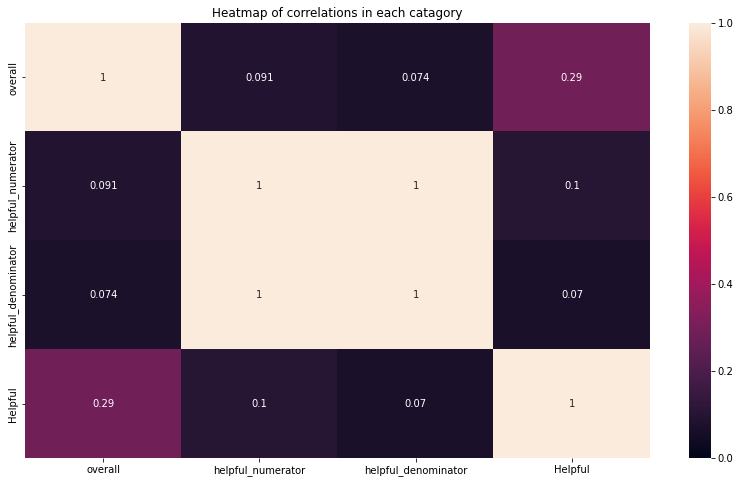

In [12]:
correlations = df1.corr()
plt.figure(figsize = FIG_SIZE)
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

Text feature generation for Benchmark model

In [13]:
df1.loc[:, 'summary'] = df1['summary'].str.lower()

df1['summary'].head(4)

33     good functions, but so many others do this and...
94     great resource with alot at your fingertips! (...
284    water is free but people still pay for bottled...
288                                can&apos;t move to sd
Name: summary, dtype: object

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

if os.path.exists('features.pickle'):
    print ('Pickled file already present, loading...')
    features = pickle.load( open( "features.pickle", "rb" ) )
    print ('Pickle file loaded.')
else:

    vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)

    features = vectorizer.fit_transform(df1['summary'])
features

<47932x24 sparse matrix of type '<class 'numpy.float64'>'
	with 30983 stored elements in Compressed Sparse Row format>

# **Benchmark model**

    Gaussian Naive Bayes (GaussianNB)
    Decision Trees
    Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
    K-Nearest Neighbours (Neighbours)
    Stochastic Gradient Descent (SGDC)
    Support Vector Machines (SVM)
    Logistic Regression

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

**Setup**

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''

    start = time()
    probas = clf.predict_proba(features)
    end = time()
    
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on roc_auc score. '''
    
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, X_train.shape[0]))

    train_classifier(clf, X_train, y_train)

    print ("ROC_AUC score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ROC_AUC score for test set: {:.4f}.\n".format(predict_labels(clf, X_test, y_test)))
    
def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

clf_list = [GaussianNB(), 
            AdaBoostClassifier(random_state = RAN_STATE), 
            RandomForestClassifier(random_state = RAN_STATE), 
            LogisticRegression(random_state = RAN_STATE),
            DecisionTreeClassifier(random_state = RAN_STATE)]
x_tr = X_train.toarray()
x_te = X_test.toarray()

train_feature_list = [x_tr[0:10000],x_tr[0:20000],x_tr]
train_target_list = [y_train[0:10000], y_train[0:20000], y_train]

for clf in clf_list:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf, a, b, x_te, y_test)

Training a GaussianNB using a training set size of 10000. . .
Trained model in 0.0053 seconds
Made predictions in 0.0044 seconds.
ROC_AUC score for training set: 0.6164.
Made predictions in 0.0052 seconds.
ROC_AUC score for test set: 0.6113.

Training a GaussianNB using a training set size of 20000. . .
Trained model in 0.0190 seconds
Made predictions in 0.0091 seconds.
ROC_AUC score for training set: 0.6108.
Made predictions in 0.0048 seconds.
ROC_AUC score for test set: 0.6136.

Training a GaussianNB using a training set size of 38345. . .
Trained model in 0.0154 seconds
Made predictions in 0.0159 seconds.
ROC_AUC score for training set: 0.6115.
Made predictions in 0.0047 seconds.
ROC_AUC score for test set: 0.6163.

Training a AdaBoostClassifier using a training set size of 10000. . .
Trained model in 0.3238 seconds
Made predictions in 0.0956 seconds.
ROC_AUC score for training set: 0.6288.
Made predictions in 0.0983 seconds.
ROC_AUC score for test set: 0.6189.

Training a AdaBoostC

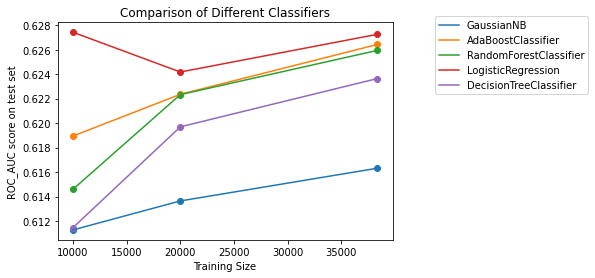

<Figure size 1008x576 with 0 Axes>

In [18]:
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a, b in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_roc_score(clf, a, b, x_te, y_test))
        x_graph.append(len(a))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show()